# Importing necessary packages

In [1]:
import os
os.listdir('../input')

['hyperverge-2022-intern-challenge']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import pandas as pd
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout


In [3]:
!pip install tfa-nightly
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.6 MB/s eta 0:00:00


# Data preprocessing

In [4]:
def frame_read(file_name):
    return pd.read_csv('../input/hyperverge-2022-intern-challenge/'+file_name)

In [5]:
def process_string(str_val):
    str_val=str_val.lower()
    str_val=str_val.split()
    return ''.join(str_val)

In [6]:
def label_Encode(frame, column_val):
    lb=LabelEncoder()
    return lb.fit_transform(frame[column_val])

In [7]:
def encoder_label(frame, column_val):
    encoder = LabelEncoder()
    encoder.fit_transform(frame[column_val])
    values = encoder.classes_
    keys = encoder.transform(encoder.classes_)
    encoder_dct = dict(zip(keys, values))
    print(encoder_dct)
    return encoder_dct

In [8]:
def preprocess():
    pass
    

In [9]:
def target_encoder(frame, column_names):
    gender_cate=tf.keras.utils.to_categorical(frame[column_names[0]], 9)
    race_cate=tf.keras.utils.to_categorical(frame[column_names[1]], 2)
    age_cate=tf.keras.utils.to_categorical(frame[column_names[2]], 7)
    return (gender_cate, race_cate, age_cate)

In [10]:
def create_list_for_frame(category_val):
    temp=[]
    for i in range(len(category_val)):
        temp.append(category_val[i])
    return temp
    

In [11]:
def update_paths(path_vals):
    return '../input/hyperverge-2022-intern-challenge/'+path_vals

In [12]:
def create_frame(frame, age_lst=None, gender_lst=None, race_lst=None):
    frame2 = pd.DataFrame()
    try:
        frame2['path'] = frame['file']
        frame2['age'] = age_lst
        frame2['gender'] = gender_lst
        frame2['race'] = race_lst
    except:
        pass
    finally:
        frame2['path']=frame2['path'].apply(update_paths)
    return frame2

In [13]:
def create_generator(frame):
    datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
    train_generator=datagen.flow_from_dataframe(
                                dataframe=frame,
                                directory=None,
                                x_col="path",
                                y_col=['age','gender','race'],
                                subset="training",
                                batch_size=32,
                                seed=42,
                                shuffle=True,
                                class_mode="multi_output",
                                target_size=(224,224))
    valid_generator=datagen.flow_from_dataframe(
                            dataframe=frame,
                            directory=None,
                            x_col="path",
                            y_col=['age','gender','race'],
                            subset="validation",
                            batch_size=32,
                            seed=42,
                            shuffle=True,
                            class_mode="multi_output",
                            target_size=(224,224))
    
    return (train_generator, valid_generator)

# Custom Architecture implementation(for multi task using functional API)

In [14]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X



In [15]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [16]:
def ResNet_custom(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
def ResNet_custom_final():
    base_model = ResNet50(input_shape=(224, 224, 3))
    headModel = base_model.output
    X = convolutional_block(headModel, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat = Flatten()(X)
    dense=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(flat)
    dense=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(dense)
    x1 = Dense( 9,activation='softmax', name='age',kernel_initializer=glorot_uniform(seed=0))(dense)

    X = convolutional_block(headModel, f=3, filters=[512, 512, 2048], stage=6, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=6, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=6, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat1 = Flatten()(X)
    dense1=Dense(256, activation='relu', name='fc3',kernel_initializer=glorot_uniform(seed=0))(flat1)
    dense1=Dense(128, activation='relu', name='fc4',kernel_initializer=glorot_uniform(seed=0))(dense1)
    x2 = Dense( 2,activation='softmax', name='gender',kernel_initializer=glorot_uniform(seed=0))(dense1)

    X = convolutional_block(headModel, f=3, filters=[512, 512, 2048], stage=7, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=7, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=7, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat2 = Flatten()(X)
    dense2=Dense(256, activation='relu', name='fc5',kernel_initializer=glorot_uniform(seed=0))(flat2)
    dense2=Dense(128, activation='relu', name='fc6',kernel_initializer=glorot_uniform(seed=0))(dense2)
    x3 = Dense( 7,activation='softmax', name='race',kernel_initializer=glorot_uniform(seed=0))(dense2)
    return Model(inputs=base_model.input, outputs=[x1,x2,x3])
    

def Efficient_custom():
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights=None, input_shape=(224,224,3),classes=9)
    base_model.trainable = True
    model_1_out = base_model.output 


    X = identity_block(model_1_out, 3, [512, 512, 1536], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat = Flatten()(X)
    dense=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(flat)
    dense=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(dense)
    x1 = Dense( 9,activation='softmax', name='age',kernel_initializer=glorot_uniform(seed=0))(dense)


    X = identity_block(model_1_out, 3, [512, 512, 1536], stage=6, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat1 = Flatten()(X)
    dense1=Dense(256, activation='relu', name='fc3',kernel_initializer=glorot_uniform(seed=0))(flat1)
    dense1=Dense(128, activation='relu', name='fc4',kernel_initializer=glorot_uniform(seed=0))(dense1)
    x2 = Dense( 2,activation='softmax', name='gender',kernel_initializer=glorot_uniform(seed=0))(dense1)


    X = identity_block(model_1_out, 3, [512, 512, 1536], stage=7, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    flat2 = Flatten()(X)
    dense2=Dense(256, activation='relu', name='fc5',kernel_initializer=glorot_uniform(seed=0))(flat2)
    dense2=Dense(128, activation='relu', name='fc6',kernel_initializer=glorot_uniform(seed=0))(dense2)
    x3 = Dense( 7,activation='softmax', name='race',kernel_initializer=glorot_uniform(seed=0))(dense2)
    return Model(inputs=base_model.input,outputs=[x1, x2, x3])
    
if True:
    #Creating a model
    model = Efficient_custom()
else:
    model = ResNet_custom_final()

2022-05-15 20:04:00.161561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 20:04:00.342365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 20:04:00.343194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 20:04:00.344423: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Call backs

In [17]:
class Callback(object):
    
    """Abstract base class used to build new callbacks.
      Attributes:
          params: dict. Training parameters
              (eg. verbosity, batch size, number of epochs...).
          model: instance of `keras.models.Model`.
              Reference of the model being trained.
          validation_data: Deprecated. Do not use.
      The `logs` dictionary that callback methods
      take as argument will contain keys for quantities relevant to
      the current batch or epoch.
      Currently, the `.fit()` method of the `Model` class
      will include the following quantities in the `logs` that
      it passes to its callbacks:
          on_epoch_end: logs include `acc` and `loss`, and
          optionally include `val_loss`
          (if validation is enabled in `fit`), and `val_acc`
          (if validation and accuracy monitoring are enabled).
          on_batch_begin: logs include `size`,
          the number of samples in the current batch.
          on_batch_end: logs include `loss`, and optionally `acc`
            (if accuracy monitoring is enabled).
      """

    def __init__(self):
        self.validation_data = None
        self.model = None
        # Whether this Callback should only run on the chief worker in a
        # Multi-Worker setting.
        # TODO(omalleyt): Make this attr public once solution is stable.
        self._chief_worker_only = None

    def set_params(self, params):
        self.params = params

    def set_model(self, model):
        self.model = model

    def on_batch_begin(self, batch, logs=None):
        """A backwards compatibility alias for `on_train_batch_begin`."""

    def on_batch_end(self, batch, logs=None):
        """A backwards compatibility alias for `on_train_batch_end`."""

    def on_epoch_begin(self, epoch, logs=None):
        """Called at the start of an epoch.
        Subclasses should override for any actions to run. This function should only
        be called during TRAIN mode.
        Arguments:
            epoch: integer, index of epoch.
            logs: dict. Currently no data is passed to this argument for this method
              but that may change in the future.
        """

    def on_epoch_end(self, epoch, logs=None):
        """Called at the end of an epoch.
        Subclasses should override for any actions to run. This function should only
        be called during TRAIN mode.
        Arguments:
            epoch: integer, index of epoch.
            logs: dict, metric results for this training epoch, and for the
              validation epoch if validation is performed. Validation result keys
              are prefixed with `val_`.
        """

    def on_train_batch_begin(self, batch, logs=None):
        """Called at the beginning of a training batch in `fit` methods.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Has keys `batch` and `size` representing the current batch
              number and the size of the batch.
        """
        # For backwards compatibility.
        self.on_batch_begin(batch, logs=logs)

    def on_train_batch_end(self, batch, logs=None):
        """Called at the end of a training batch in `fit` methods.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Metric results for this batch.
        """
        # For backwards compatibility.
        self.on_batch_end(batch, logs=logs)

    def on_test_batch_begin(self, batch, logs=None):
        """Called at the beginning of a batch in `evaluate` methods.
        Also called at the beginning of a validation batch in the `fit`
        methods, if validation data is provided.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Has keys `batch` and `size` representing the current batch
                  number and the size of the batch.
        """

    def on_test_batch_end(self, batch, logs=None):
        """Called at the end of a batch in `evaluate` methods.
        Also called at the end of a validation batch in the `fit`
        methods, if validation data is provided.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Metric results for this batch.
        """

    def on_predict_batch_begin(self, batch, logs=None):
        """Called at the beginning of a batch in `predict` methods.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Has keys `batch` and `size` representing the current batch
                  number and the size of the batch.
        """

    def on_predict_batch_end(self, batch, logs=None):
        """Called at the end of a batch in `predict` methods.
        Subclasses should override for any actions to run.
        Arguments:
            batch: integer, index of batch within the current epoch.
            logs: dict. Metric results for this batch.
        """

    def on_train_begin(self, logs=None):
        """Called at the beginning of training.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
                  but that may change in the future.
        """

    def on_train_end(self, logs=None):
        """Called at the end of training.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
                  but that may change in the future.
        """

    def on_test_begin(self, logs=None):
        """Called at the beginning of evaluation or validation.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
              but that may change in the future.
        """

    def on_test_end(self, logs=None):
        """Called at the end of evaluation or validation.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
              but that may change in the future.
        """

    def on_predict_begin(self, logs=None):
        """Called at the beginning of prediction.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
              but that may change in the future.
        """

    def on_predict_end(self, logs=None):
        """Called at the end of prediction.
        Subclasses should override for any actions to run.
        Arguments:
            logs: dict. Currently no data is passed to this argument for this method
              but that may change in the future.
    """

In [18]:
class Custom_Scores(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc, micro_f1, auc]
        #print(logs.keys(), 'on train begin')
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [], 'f1_age':[], 'f1_gender':[], 'f1_race':[]}
        #lprint(logs.keys(), 'on train begin')

    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        #print(logs.keys(), 'on epoch end')
        self.history['loss'].append(logs.get('loss'))
        self.history['acc'].append(logs.get('acc'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_acc'].append(logs.get('val_acc'))

        y_pred = self.model.predict(valid_generator)
        #print(y_pred[:5])
        # auc = roc_auc_score(y_test, y_pred)
        # y_pred = list((int(i>0.5) for i in y_pred))
        metric1 = tfa.metrics.F1Score(num_classes=9, threshold=0.5)
        metric2 = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
        metric3 = tfa.metrics.F1Score(num_classes=7, threshold=0.5)

        metric1.update_state(valid_generator.labels[0], y_pred[0])
        result1 = metric1.result()
        metric2.update_state(valid_generator.labels[1], y_pred[1])
        result2 = metric2.result()
        metric3.update_state(valid_generator.labels[2], y_pred[2])
        result3 = metric3.result()
        

#         f1_scr = f1_score(y_test,y_pred)
        age_f1=result1.numpy().mean()
        gender_f1=result2.numpy().mean()
        race_f1=result3.numpy().mean()
        logs['f1_age'] = age_f1
        logs['f1_gender'] = gender_f1
        logs['f1_race'] = race_f1
        self.history["f1_age"].append(age_f1)
        self.history["f1_gender"].append(gender_f1)
        self.history["f1_race"].append(race_f1)
        # micro_f1=f1_score(y_test, y_pred, average='micro')
        # self.history['micro_f1'].append(micro_f1)
        # self.history['auc'].append(auc)
        # # #print(logs.keys())
        # # logs['micro_f1'] = micro_f1
        # # logs['auc'] = auc
        # # print(logs.keys())
        # # print(self.history)

        print(' - INFO: val_age_f1 : ',str(age_f1)+' - val_gender_f1 : ',str(gender_f1)+' - val_race_f1 : ',str(race_f1))

# Visualising the network

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

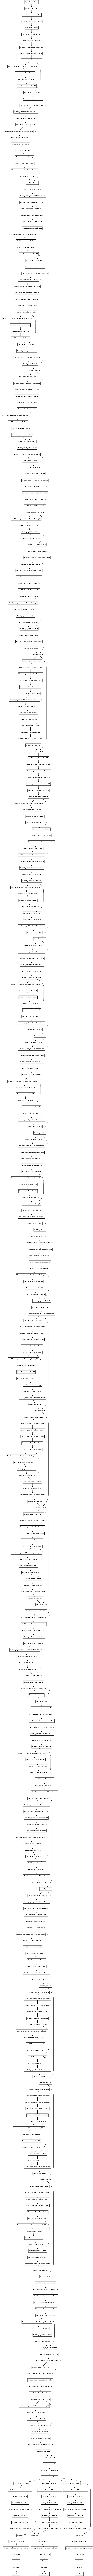

In [20]:
plot_model(model, 'net_arch.png')

In [21]:
%%time

train=frame_read('train.csv')
test=frame_read('test.csv')

train['race_updated']=train['race'].apply(process_string)
train['gender_updated']=train['gender'].apply(process_string)

age_dct=encoder_label(train, 'age')
gender_dct=encoder_label(train, 'gender')
race_dct=encoder_label(train, 'race')

train['age_updated']=label_Encode(train, 'age')
train['gender_updated']=label_Encode(train, 'gender_updated')
train['race_updated']=label_Encode(train, 'race_updated')

age_cate, gender_cate, race_cate= target_encoder(train, ['age_updated', 'gender_updated', 'race_updated'])

age_list=create_list_for_frame(age_cate)
gender_list=create_list_for_frame(gender_cate)
race_list=create_list_for_frame(race_cate)

train=create_frame(train, age_lst=age_list, gender_lst=gender_list, race_lst=race_list)
test['path']=test['file'].apply(update_paths)

train_generator, valid_generator = create_generator(train)


{0: '0-2', 1: '10-19', 2: '20-29', 3: '3-9', 4: '30-39', 5: '40-49', 6: '50-59', 7: '60-69', 8: 'more than 70'}
{0: 'Female', 1: 'Male'}
{0: 'Black', 1: 'East Asian', 2: 'Indian', 3: 'Latino_Hispanic', 4: 'Middle Eastern', 5: 'Southeast Asian', 6: 'White'}
Found 65058 validated image filenames.
Found 21686 validated image filenames.
CPU times: user 4.07 s, sys: 4.56 s, total: 8.63 s
Wall time: 4min 10s


In [22]:
cust_scr=Custom_Scores()
from tensorflow.keras.callbacks import LearningRateScheduler   
def lr_update(epoch,lr):
  if len(cust_scr.history['val_acc'])>1 and cust_scr.history["val_acc"][-1]<cust_scr.history["val_acc"][-2]: #decreasing learning rate if val_accuracy is not decreased
    return (lr - (0.01*lr))
  # if epoch%3==0:
  #   lr = lr - (0.05*lr) #decreasing learning rate at every 3rd epoch

  
  return (lr-(0.001*lr))
lr_callback = LearningRateScheduler(lr_update,verbose=1)

In [23]:
log_dir="logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

path="checkpopint_save.hdf5"
model_check = ModelCheckpoint(filepath=path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

terminate = TerminateOnNaN()
learning_rate = LearningRateScheduler(lr_update,verbose=1)

early_stop = EarlyStopping(monitor="val_accuracy",patience=3,mode='auto')

call_back=[cust_scr, tensorboard,model_check,terminate,early_stop]

2022-05-15 20:08:21.014389: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-15 20:08:21.014437: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-15 20:08:21.016514: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-15 20:08:21.224482: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-15 20:08:21.224658: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.fit(train_generator,epochs=7,validation_data=valid_generator,callbacks=call_back)

2022-05-15 20:08:22.267971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-05-15 20:08:36.883960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/2034 [..............................] - ETA: 12:26:37 - loss: 5.5524 - age_loss: 2.3408 - gender_loss: 0.9989 - race_loss: 2.2128 - age_accuracy: 0.1875 - gender_accuracy: 0.3125 - race_accuracy: 0.1562

2022-05-15 20:08:44.735426: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-15 20:08:44.735494: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2034 [..............................] - ETA: 39:04 - loss: 7.4336 - age_loss: 3.0221 - gender_loss: 1.8052 - race_loss: 2.6063 - age_accuracy: 0.1719 - gender_accuracy: 0.3438 - race_accuracy: 0.0938   

2022-05-15 20:08:45.496933: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-15 20:08:45.500891: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-15 20:08:45.676541: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3884 callback api events and 3876 activity events. 
2022-05-15 20:08:45.775964: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-15 20:08:45.894505: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs2/fit/20220515-200821/train/plugins/profile/2022_05_15_20_08_45

2022-05-15 20:08:45.956743: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs2/fit/20220515-200821/train/plugins/profile/2022_05_15_20_08_45/f0ed634c4299.trace.json.gz
2022-05-15 20:08:46.116188: I tensorflow/core/profiler/rpc/client/save_profile

2034/2034 [==============================] - 1103s 532ms/step - loss: 4.5716 - age_loss: 1.8995 - gender_loss: 0.7094 - race_loss: 1.9626 - age_accuracy: 0.2837 - gender_accuracy: 0.5261 - race_accuracy: 0.1854 - val_loss: 4.5408 - val_age_loss: 1.9198 - val_gender_loss: 0.6899 - val_race_loss: 1.9312 - val_age_accuracy: 0.2857 - val_gender_accuracy: 0.5658 - val_race_accuracy: 0.2204
 - INFO: val_age_f1 :  0.0017678711 - val_gender_f1 :  0.44682992 - val_race_f1 :  0.0017239458
Epoch 2/7
2034/2034 [==============================] - 935s 460ms/step - loss: 4.2518 - age_loss: 1.7677 - gender_loss: 0.6540 - race_loss: 1.8301 - age_accuracy: 0.3212 - gender_accuracy: 0.6069 - race_accuracy: 0.2687 - val_loss: 4.0420 - val_age_loss: 1.6711 - val_gender_loss: 0.6055 - val_race_loss: 1.7655 - val_age_accuracy: 0.3522 - val_gender_accuracy: 0.6568 - val_race_accuracy: 0.3328
 - INFO: val_age_f1 :  0.007881472 - val_gender_f1 :  0.4900797 - val_race_f1 :  0.031482495
Epoch 3/7
2034/2034 [=====

In [26]:
os.listdir('/kaggle/working')

['logs2', 'net_arch.png', '__notebook__.ipynb']

In [27]:
test.shape

(10954, 2)

In [28]:
total_val=len(test['file'].values)
bathes_val=len(test['file'].values)//32
remined_batch=total_val-bathes_val*32
range_val=len(test['file'].values)//32
predictions=[]

from tqdm import tqdm
start=0
age_predictions=[]
gender_predictions=[]
race_predictions=[]
range_val=1
try:
  for i in tqdm(range(bathes_val)):
    test_images_array=[]
    for each in test['path'].values[start:(i+1)*32]:
      img=cv2.imread(each)
      img=img[:,:,[2,1, 0]]
      img=img/255.
      test_images_array.append(img)
      start+=1
    test_images_array=np.asarray(test_images_array)
    preds=model.predict(test_images_array)
    for j in range(len(preds)):
      for k in range(len(preds[j])):
        if(j==0):
          age_predictions.append(np.argmax(preds[j][k]))
        if(j==1):
          gender_predictions.append(np.argmax(preds[j][k]))
        if j==2:
          race_predictions.append(np.argmax(preds[j][k]))
    
  test_images_array=[]
  for each in test['path'].values[start:]:
    img=cv2.imread(each)
    img=img[:,:,[2,1, 0]]
    img=img/255.
    test_images_array.append(img)
    start+=1
  test_images_array=np.asarray(test_images_array)
  preds=model.predict(test_images_array)
  for j in range(len(preds)):
    for k in range(len(preds[j])):
      if(j==0):
        age_predictions.append(np.argmax(preds[j][k]))
      if(j==1):
        gender_predictions.append(np.argmax(preds[j][k]))
      if j==2:
        race_predictions.append(np.argmax(preds[j][k]))
except Exception as e: 
  print("WARNING/ERROR : {}".format(e))


100%|██████████| 342/342 [02:36<00:00,  2.18it/s]


In [29]:
age_predictions[:5]

[3, 6, 4, 2, 5]

In [30]:
final_pred_age=[]
final_pred_gender=[]
final_pred_race=[]
for i, j, k in zip(age_predictions, gender_predictions, race_predictions):
  # print(i, j, k)
  final_pred_age.append(age_dct[i])
  final_pred_gender.append(gender_dct[j])
  final_pred_race.append(race_dct[k])
print(len(final_pred_age), len(final_pred_gender), len(final_pred_race))

10954 10954 10954


In [31]:
final_submission_csv=pd.DataFrame()
final_submission_csv['file']=test['file'].values
final_submission_csv['age']=final_pred_age
final_submission_csv['gender']=final_pred_gender
final_submission_csv['race']=final_pred_race

In [32]:
final_submission_csv.head()

,file,age,gender,race
0,test/1.jpg,3-9,Male,Indian
1,test/2.jpg,50-59,Female,Southeast Asian
2,test/3.jpg,30-39,Male,Middle Eastern
3,test/4.jpg,20-29,Female,White
4,test/5.jpg,40-49,Female,East Asian


In [33]:
final_submission_csv.shape

(10954, 4)

In [34]:
final_submission_csv.to_csv('submission.csv', index=False)